In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc

2024-02-01 19:04:17.445968: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 19:04:17.509825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import tensorflow as tf

# Check GPUs available
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs Available: {gpus}")

# Check if TensorFlow is currently executing eagerly (which means operations are executed as they are defined and is the default mode in TF 2.x)
print(f"Eager execution: {tf.executing_eagerly()}")

# If you have GPUs listed and eager execution is enabled, then operations should automatically run on the GPU if possible.
# To test if TensorFlow will place tensors and operations on the GPU by default, you can create a simple operation and see where it is placed:
if gpus:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        print(a.device)
else:
    print("No GPU found!")

In [2]:
# This is the list that will hold all of the data (data22 and MC)

datasets = []
tags = ['data', 'HHbbttHadHad', 'ZZ4lep', 'Ztautau', 'jj']

In [3]:
# Read EB data22 file

with h5py.File('../ntuples/AOD_EB_ntuples_1-26-2024.h5', 'r') as hf:
    jets = hf['HLT_jets'][:]
    electrons = hf['electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    muons = hf['muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    photons = hf['photons'][:]
    MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

In [4]:
print(jets.shape)

(1019220, 10, 4)


In [5]:
# Collect only events that passed any of our unprescaled L1 list, and concatenate.

pass_L1_idxs = (pass_L1_unprescaled == 1) # Indices of events that passed L1
data = np.concatenate([jets[pass_L1_idxs], electrons[pass_L1_idxs], muons[pass_L1_idxs], photons[pass_L1_idxs], MET[pass_L1_idxs]], axis=1)
weights = EB_weights[pass_L1_idxs]
datasets.append(data)

In [6]:
# Read MC data

filenames = ['MC_HHbbttHadHad_ntuples.h5', 'MC_ZZ4lep_ntuples.h5', 'MC_Ztautau_ntuples.h5', 'MC_jj_ntuples.h5']
data_path = '../ntuples/'

for filename in filenames:
    with h5py.File(data_path+filename, 'r') as hf:
        jets = hf['jets'][:]
        electrons = hf['electrons'][:]
        muons = hf['muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets.append(combined_data)

In [7]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for i, data in enumerate(datasets):

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 3])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

In [8]:
for i, dataset in enumerate(datasets):
    print(f'{tags[i]}: {dataset.shape}')

data: (224294, 20, 4)
HHbbttHadHad: (10000, 20, 4)
ZZ4lep: (9998, 20, 4)
Ztautau: (39901, 20, 4)
jj: (5000, 20, 4)


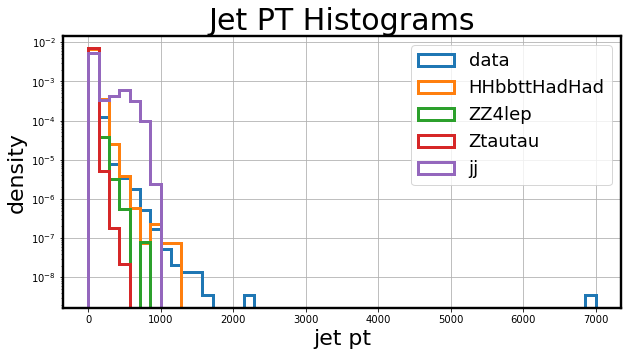

In [9]:
# Plotting pt distribtions of the jets from each dataset

plt.figure(figsize=(10, 5))
plt.rcParams['axes.linewidth'] = 2.4
bins = np.linspace(0, 7000, 50)
#bins=50

for i, tag in enumerate(tags):
    pt = datasets[i][:, :10, 0]
    pt = pt[pt > 0]

    plt.hist(pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3)

plt.yscale('log')
plt.xlabel('jet pt', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.title('Jet PT Histograms', fontsize=30)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [10]:
# Flatten ndarrays for use in DNN

for i, data in enumerate(datasets):
    datasets[i] = np.reshape(data, newshape=(-1, 80))

for i, data in enumerate(datasets):
    print(f'{tags[i]}: {data.shape}')

data: (224294, 80)
HHbbttHadHad: (10000, 80)
ZZ4lep: (9998, 80)
Ztautau: (39901, 80)
jj: (5000, 80)


In [11]:
# Reparameterization
def sampling(args):
    """This function will be used in the reparameterization step of the VAE."""
    z_mean, z_log_var, latent_dim = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    std = K.exp(0.5 * z_log_var)
    return z_mean + std * epsilon

In [12]:
def create_VAE(input_dim, h_dim_1, h_dim_2, latent_dim, beta=0.4):
    """Creates a vae, and also the encoder and decoder in case of separate use.
    INPUTS:
    
    input_dim, h_dim_1, h_dim_2, latent_dim: These specify the stucture of the VAE.
    The shape will be input_dim --> h_dim_1 --> h_dim_2 --> latent_dim and then back up.

    beta: The parameter that determines the tuning between the KL and MSE loss.
    
    OUTPUTS:

    vae, encoder, decoder: keras models of the VAE, encoder (with reparameterization), and decoder.
    """

    # Encoder
    inputs = layers.Input(shape=(input_dim))
    x = layers.Dense(h_dim_1, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    z = layers.Lambda(sampling)([z_mean, z_log_var, latent_dim]) # This wraps the 'sampling' function as a 'Layer' object
    
    # Decoder
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h_dim_2, activation='relu')(decoder_input)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)
    
    # Decoder Model
    decoder = Model(decoder_input, outputs)
    
    # VAE model
    vae_outputs = decoder(z)
    vae = Model(inputs, vae_outputs)
    
    # Encoder Model including reparameterization
    encoder = Model(inputs, [z_mean, z_log_var, z])
    
    # -------------------------------------------------------------------------------------------------------
    # Now let's define the loss function. We will use a combination of MSE and KL loss.

    recon_loss = K.mean(K.square(inputs - vae_outputs))
    kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
    total_loss = (1 - beta) * recon_loss + beta * kl_loss
    vae.add_loss(total_loss)

    return vae, encoder, decoder

In [13]:
# Make train, test, val splits

TRAIN_SIZE = 0.6
VAL_SIZE = 0.2
TEST_SIZE = 0.2

X_train, X_ = train_test_split(datasets[0], train_size=TRAIN_SIZE)
X_val, X_test = train_test_split(X_, train_size=0.5)

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')

X_train: (134576, 80)
X_val: (44859, 80)
X_test: (44859, 80)


In [14]:
# Initialize model
INPUT_DIM = X_train.shape[1]
H_DIM_1 = 32
H_DIM_2 = 16
LATENT_DIM = 8
vae, encoder, decoder = create_VAE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 32)                   2592      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 16)                   528       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 8)                    136       ['dense_1[0][0]']             
                                                                                            

In [15]:
vae.compile(optimizer='adam')

In [16]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 8
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [17]:
NUM_EPOCHS = 50
BATCH_SIZE = 1024

In [18]:
history = vae.fit(x=X_train, y=X_train, validation_data=(X_val, X_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/50
132/132 [==============================] - 3s 9ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 4/50
121/132 [==========================>...] - ETA: 0s - loss: nan
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 1s 6ms/step - loss: nan - val_loss: nan - lr: 1.0000e-04
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan - lr: 1.0000e-04
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan - lr: 1.0000e-04
Epoch 8/50
124/132 [===========================>..] - ETA: 0s - loss: nan
Epoch 8: ReduceLROnPlatea

In [19]:
arr_ = X_val
print(f'any nan or inf values? {np.isfinite(arr_).any()}')

nan_count = np.sum(np.isnan(arr_))
inf_count = np.sum(np.isinf(arr_))
print(f'nan count: {nan_count}')
print(f'inf count: {inf_count}')

any nan or inf values? True
nan count: 0
inf count: 0


In [ ]:
nan_indices = np.argwhere(np.isnan(arr_))
for index in nan_indices[0:5]:
    print(f"NaN found at index: {index[0]}")

In [ ]:
predictions = vae.predict(X_test)
print(predictions.shape)

In [ ]:
print(predictions[0])

In [ ]:
print(predictions[0])